In [1]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks, detrend, savgol_filter
from scipy.fft import rfft, rfftfreq

In [2]:
record = wfdb.rdrecord("bidmc01")

ppg  = record.p_signal[:,0]   # channel 0 = PPG
resp = record.p_signal[:,1]   # channel 1 = respiration belt
fs   = record.fs              # 125 Hz sampling rate

print("Sampling rate:", fs, "Hz")
print("Durasi:", len(ppg)/fs, "detik")

Sampling rate: 125 Hz
Durasi: 480.008 detik


In [ ]:
def bandpass(sig, fs, low=0.7, high=4.0, order=3):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, sig)

ppg_filt = bandpass(ppg, fs)
ppg_det  = detrend(ppg_filt)

In [ ]:
def extract_hr_from_ppg(ppg_win, fs):
    thr = np.percentile(ppg_win, 75)
    peaks, _ = find_peaks(
        ppg_win,
        distance=0.35*fs,                  # min spacing for HR up to ~170 bpm
        height=thr,
        prominence=np.std(ppg_win)*0.3
    )
    
    if len(peaks) < 4:
        return None, None, None

    t_peaks = peaks / fs
    ibi     = np.diff(t_peaks)
    hr      = 60.0 / ibi
    t_hr    = t_peaks[1:]

    # Smooth HR
    if len(hr) >= 11:
        hr_smooth = savgol_filter(hr, 11, 3)
    else:
        hr_smooth = hr

    return t_hr, hr_smooth, ibi

In [ ]:
def extract_surrogates(ppg_win, t_hr, hr_smooth, ibi, fs):
    thr = np.percentile(ppg_win, 75)
    peaks, _ = find_peaks(
        ppg_win,
        distance=0.35*fs,
        height=thr,
        prominence=np.std(ppg_win)*0.3
    )
    
    if len(peaks) < 4:
        return None, None, None

    t_peaks = peaks / fs
    ppg_dt  = detrend(ppg_win)

    # Interpolasi amplitude ke domain waktu HR
    RIAV = np.interp(t_hr, t_peaks, ppg_dt[peaks])

    # Interval & HR midpoints
    t_mid  = (t_hr[:-1] + t_hr[1:]) / 2
    RIIV   = ibi[1:]     # interval
    RIFV   = hr_smooth[1:]

    if len(t_mid) < 4:
        return None, None, None

    RIIV_i = np.interp(t_hr, t_mid, RIIV)
    RIFV_i = np.interp(t_hr, t_mid, RIFV)

    L = min(len(RIAV), len(RIIV_i), len(RIFV_i))
    return RIAV[:L], RIIV_i[:L], RIFV_i[:L]

In [6]:
def fourier_product(RIAV, RIIV, RIFV):
    if len(RIAV) < 8:
        return None

    def norm(x):
        return detrend((x - np.mean(x)) / (np.std(x) + 1e-8))

    a = norm(RIAV)
    i = norm(RIIV)
    f = norm(RIFV)

    N = len(a)
    dt = 0.5   # surrogate sampling ~2 Hz
    freqs = rfftfreq(N, dt)

    A = np.abs(rfft(a))
    I = np.abs(rfft(i))
    F = np.abs(rfft(f))

    # L2 normalization
    A /= (np.linalg.norm(A) + 1e-8)
    I /= (np.linalg.norm(I) + 1e-8)
    F /= (np.linalg.norm(F) + 1e-8)

    P = A * I * F

    mask = (freqs >= 0.1) & (freqs <= 0.5)
    if not np.any(mask):
        return None

    f_peak = freqs[mask][np.argmax(P[mask])]
    return f_peak * 60

In [ ]:
def rr_gt(resp_win, fs):
    peaks, _ = find_peaks(
        resp_win,
        distance=0.6*fs,
        prominence=np.std(resp_win)*0.2
    )
    if len(peaks) < 2:
        return None

    ibi = np.diff(peaks) / fs
    return 60 / np.mean(ibi)

In [8]:
win_sec  = 40
step_sec = 5

RR_est_all = []
RR_gt_all  = []

for start in range(0, len(ppg_det) - win_sec*fs, step_sec*fs):
    ppg_win  = ppg_det[start:start+win_sec*fs]
    resp_win = resp[start:start+win_sec*fs]

    t_hr, hr_smooth, ibi = extract_hr_from_ppg(ppg_win, fs)
    if t_hr is None:
        continue

    sur = extract_surrogates(ppg_win, t_hr, hr_smooth, ibi, fs)
    if sur[0] is None:
        continue
    RIAV, RIIV, RIFV = sur

    RR_est = fourier_product(RIAV, RIIV, RIFV)
    RR_gtv = rr_gt(resp_win, fs)

    if RR_est is not None and RR_gtv is not None:
        RR_est_all.append(RR_est)
        RR_gt_all.append(RR_gtv)

In [9]:
RR_est_all = np.array(RR_est_all)
RR_gt_all  = np.array(RR_gt_all)

MAE = np.mean(np.abs(RR_est_all - RR_gt_all))
print("MAE:", MAE, "BPM")

MAE: 74.63248783685528 BPM


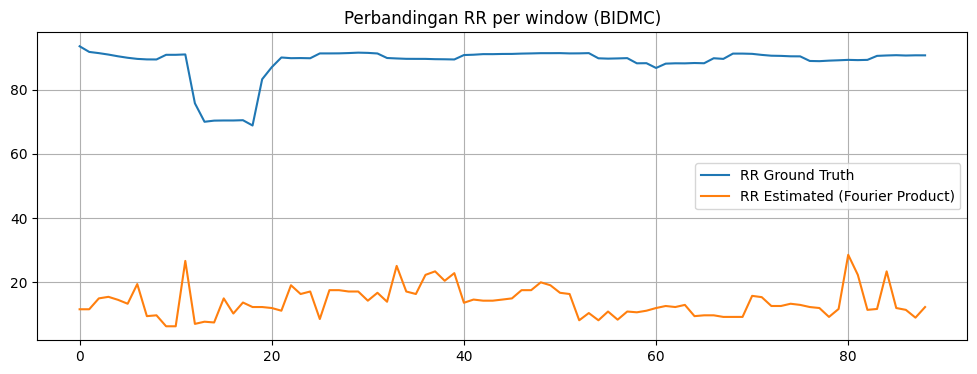

In [10]:
plt.figure(figsize=(12,4))
plt.plot(RR_gt_all, label="RR Ground Truth")
plt.plot(RR_est_all, label="RR Estimated (Fourier Product)")
plt.legend()
plt.grid(True)
plt.title("Perbandingan RR per window (BIDMC)")
plt.show()